In [1]:
%pylab inline
import numpy as np
import cPickle as pickle
import tensorflow as tf
import sys
sys.path.append('../')
import synthetic

ERROR (theano.sandbox.cuda): nvcc compiler not found on $PATH. Check your nvcc installation and try again.
ERROR:theano.sandbox.cuda:nvcc compiler not found on $PATH. Check your nvcc installation and try again.


Populating the interactive namespace from numpy and matplotlib


In [2]:
N = 400
G = synthetic.latent_space_ring(N, 2, gauss_size=0.4)

obs = synthetic.get_adj_mat(G)
neurondf = synthetic.get_nodes_to_df(G)
connection_matrix = (obs> 0).astype(np.float32)

xtrue.shape= (400, 2)
(400, 400)
(400, 400)


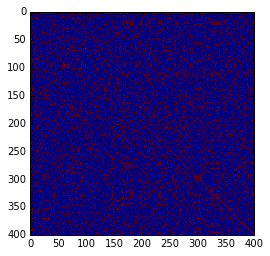

In [3]:
pylab.imshow(obs)

In [9]:
class Logistic(object):
    def __init__(self, mean, scale=10.0):
        self.mean = mean
        self.scale = scale
        
    def cost(self):
        def log_likelihood_func(obs, theta):

            p = 1.0 / (1.0 + tf.exp(-(theta - self.mean)*self.scale))
            return obs*tf.log(p) + (1-obs)*tf.log(1-p)

        return log_likelihood_func

    def obs_forward(self, x):
        """
        go from kernel val to observations
        """
        r = 1.0 / (1.0 + np.exp(-(x - self.mean)*self.scale))
        self.r = r
        return (np.random.rand(*x.shape) < r).astype(np.int)

    


# outer product

D = 2
N = len(connection_matrix)
# Set model weights


X = tf.Variable(np.random.normal(0, 10, (N, D)).astype(np.float32), name='X')
#obs = tf.pl

obs = tf.placeholder(tf.float32, (N, N), name='obs')
obsvalid = tf.placeholder(tf.float32, (N, N), name='obs')

sigma = tf.Variable(1.0)

logistic = Logistic(0.5, scale=10.0)

diff = tf.reshape(X, (tf.shape(X)[0], 1, -1)) - tf.reshape(X, (1, tf.shape(X)[0], -1))

euclidean_dist_2 = tf.reduce_sum(diff **2, 2)
alpha = 2.0

kern = (1.0 + euclidean_dist_2/(2 * sigma**2 * alpha))**(-alpha)

likelihood = logistic.cost()
res = likelihood(obs, kern) * obsvalid


cost = -tf.reduce_sum(res) + tf.reduce_sum(X**2)

learning_rate = 1.0
opt_step = tf.train.AdamOptimizer(learning_rate).minimize(cost, var_list=[X])

obsvalid_val = (np.random.rand(N, N) > 0.0)
obsvalid_val |= obsvalid_val.T

# Initializing the variables
init = tf.initialize_all_variables()
x_hist = []
ITERS = 10000
with tf.Session() as sess:
    sess.run(init)
    x_hist.append(sess.run(X))
    for i in range(ITERS):
        _, c = sess.run([opt_step, cost], feed_dict={ obs: connection_matrix, 
                                                     obsvalid : obsvalid_val.astype(float), 
                                                     sigma: 2.0 })
        if i % 100 == 0:
            print i, c, np.sum(obsvalid_val) / float(obsvalid_val.shape[0])**2

            x_hist.append(sess.run(X))

0 206699.0 1.0
100 38343.9 1.0
200 34519.9 1.0
300 26973.4 1.0
400 26969.0 1.0
500 26969.0 1.0
600 26969.0 1.0
700 26969.8 1.0
800 26970.6 1.0
900 26980.0 1.0
1000 26973.6 1.0
1100 26993.5 1.0
1200 26978.1 1.0
1300 26981.4 1.0
1400 27002.0 1.0
1500 27039.0 1.0
1600 26983.9 1.0
1700 27022.4 1.0
1800 27008.1 1.0
1900 27015.2 1.0
2000 26987.8 1.0
2100 27069.0 1.0
2200 27008.0 1.0
2300 26992.1 1.0
2400 27031.2 1.0
2500 27106.2 1.0
2600 26993.8 1.0
2700 26979.1 1.0
2800 26994.1 1.0
2900 27018.5 1.0
3000 26998.6 1.0
3100 27015.2 1.0
3200 27006.2 1.0
3300 26983.5 1.0
3400 27000.6 1.0
3500 26976.9 1.0
3600 26992.9 1.0
3700 26981.7 1.0
3800 27012.2 1.0
3900 26986.2 1.0
4000 27038.7 1.0
4100 27008.5 1.0
4200 27040.1 1.0
4300 27061.0 1.0
4400 26976.1 1.0
4500 27026.5 1.0
4600 26975.4 1.0
4700 26976.9 1.0
4800 26996.2 1.0
4900 26995.9 1.0
5000 26993.7 1.0
5100 27010.3 1.0
5200 27016.9 1.0
5300 26984.9 1.0
5400 26989.2 1.0
5500 27002.5 1.0
5600 26984.1 1.0
5700 27054.3 1.0
5800 27013.6 1.0
5900 270

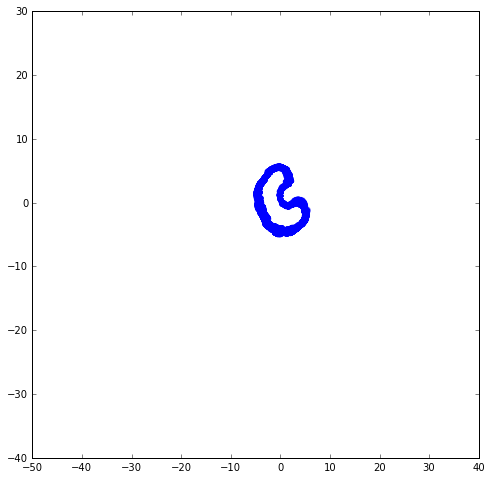

In [10]:
pylab.figure(figsize=(8, 8))
for i in range(len(x_hist)):
    pylab.scatter(x_hist[i][:, 0], x_hist[i][:, 1], alpha= (float(i)/len(x_hist))**2, edgecolor='none')
#pylab.xlim(0.110, 0.120)
#pylab.ylim(-.02, -0.005)

In [6]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

In [11]:
from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(xlim=(-40, 40), ylim=(-40, 40))
sc = ax.scatter([], [])

# initialization function: plot the background of each frame
def init():
    sc.set_offsets([])
    return sc,

# animation function.  This is called sequentially
def animate(i):
    
    sc.set_offsets(x_hist[i][:, :2])
    return sc,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(x_hist), interval=20, blit=True)

# call our new function to display the animation
display_animation(anim)
